# <center> <font color = 'rebeccapurple'>Stochastic Watershed Model: Generating Stochastic Streamflows for the Shasta River</font> </center>

This Jupyter Notebook contains code for a stochastic watershed model (SWM) that can be used to develop an ensemble of stochastic streamflows for a single site. This code was used to produce the results found in **Shabestanipour et al. (2024)** for the Shasta River basin. With modifications to the input data and the specific ARMA model used (more details below), this code could be applied to other non-regulated river basins. 

This notebook is split into two parts: 1. SWM (generating stochastic streamflows) and 2. Diagnostics (assessing stochastic model performance).

***

**Computational Requirements**: We used Jupyter version 4.7.1 and Python version 3.8.8 to run the below code. Lower versions may result in error messages.

The code is somewhat computationally-intesnive. We found that allocating 32GB of memory allowed the code to run in full without crashing the kernel. 

The code blocks that will take the longest are generating the stochastic residuals in Part 1 and generating the figure inputs in Part 2 (depending on how many stochastic realizations you do). These should each take approx. 10 min maximum. Most other code blocks run very quickly. The code to generate AIC/BIC for various ARIMA models to determine which to use may also take some time (by default this code block is commented out).

***

# <center> <font color = 'red'> Part 1: SWM </font> </center>

## <font color='green'> Import Statements </font>

Here we import SWM functions (developed by Ghazal Shabestanipour) as well as existing external Python packages used in the notebook. Be sure that the file **Func_Lib.py** is contained in the same directory as this Jupyter Notebook.
For existing Python packages, if you do not have a particular package installed with your version of Python, you can install it using pip or conda (if using anaconda). Instructions for doing so can be found here:<br>
https://packaging.python.org/en/latest/tutorials/installing-packages/ (pip)<br>
https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/installing-with-conda.html (conda)

In [1]:
# functions developed by Ghazal:
import Func_Lib_forAbby as func

# general packages
import numpy as np #numpy is a scientific computing package
import pandas as pd #pandas is a data analysis package
import math #math contains math functions
import time #functions in this package can be used to understand how long the code is taking to run
import os #functions related to operating system

# plotting packages
import matplotlib.pyplot as plt #matplotlib.pyplot is used for plotting
import seaborn as sns #seaborn is a plotting package
plt.style.use('seaborn-white') #this is the specific style of plotting used

# statistical analysis packages
from scipy import stats #scipy.stats are functions related to statistical analysis
from scipy.stats import norm #functions for normally distributed random variable 

# time series analysis packages
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf #function to plot autocorrelation function (acf) for time series analysis
from statsmodels.graphics.tsaplots import plot_pacf #function to plot partial autocorrelation function (pacf) for time series analysis
#from statsmodels.tsa.arima_model import ARIMA #import function for ARIMA (time series analysis)
from statsmodels.tsa.arima.model import ARIMA

## <font color='green'> Load Input Data </font>

The only input data required is a csv containing daily streamflow data (observed and modeled). The columns of the csv are $date$, observed streamflow $Qgage$, deterministic model of streamflow $Qmodel$, and the difference between Qgage and Qmodel for each date $diff$.

For the Squannacook, we have values from 10/01/1987 - 09/30/2018.

In [2]:
# read in the csv of streamflow data and assign to variable called "data"
data = pd.read_csv('SWM-data_cond-debias.csv') #columns are date, Qgage (observed), Qmodel (deterministic model), and diff (Qmodel - Qgage)

data['month'] = pd.DatetimeIndex(data['date']).month #create a DatetimeIndex column for month
data['date'] = pd.to_datetime(data['date']) #convert format of "date" column to Datetime (for time series analysis)

#convert units to m^3/s 
# mm/day * SHA area in mi2 * (1609.34^2 m^2/mi^2) * (10^-3 m/1 mm) * (1 day/24*3600 s)
area_mi2_SHA = 6665 #area for Shasta baisn in sq. mi. from Zach Brodeur
data['Qgage'] = data['Qgage']*area_mi2_SHA*(1609.34**2)*(10**-3)/(24*3600)
data['Qmodel'] = data['Qmodel']*area_mi2_SHA*(1609.34**2)*(10**-3)/(24*3600)

# generating empirical log-ratio errors
data['lambda'] = np.log(data['Qmodel'] / data['Qgage']) #calculate the lambda = log(Qmodel/Qgage)
data['raw diff'] = data['Qmodel'] - data['Qgage']
data.head(5) #display first five rows of data

,date,Qgage,Qmodel,month,lambda,raw diff
0,1987-10-01,59.938142,366.261850,10,1.810035,306.323708
1,1987-10-02,99.896904,735.416652,10,1.996299,635.519749
2,1987-10-03,99.896904,550.188717,10,1.706123,450.291814
3,1987-10-04,79.917523,421.519228,10,1.662870,341.601705
4,1987-10-05,99.896904,336.630618,10,1.214848,236.733714


In [3]:
def calc_NSE(obs,sim):
    """ Returns Nash-Sutcliffe Efficiency
    Input:
    obs - array of observed streamflow record
    sim - array of simulated streamflow record """
    return 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))

nse_sq = calc_NSE(data.Qgage,data.Qmodel)
nse_sq

0.8555901625366116

Below we plot the distribution of the lambdas to ensure that they're roughly normally distributed

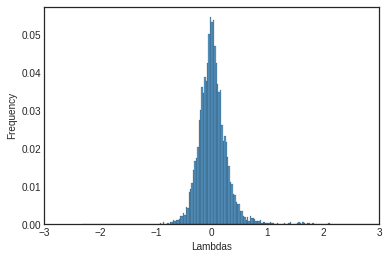

In [4]:
sns.histplot(data['lambda'],stat='probability')
plt.xlabel('Lambdas')
plt.ylabel('Frequency')
plt.xlim([-3, 3])
plt.show()

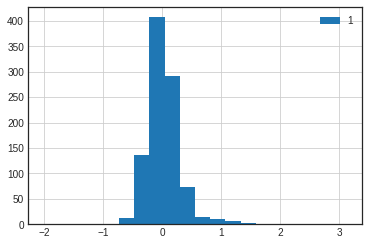

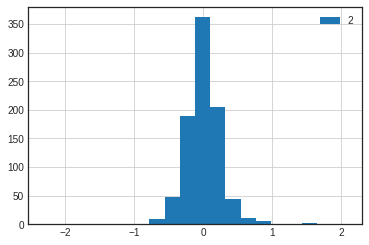

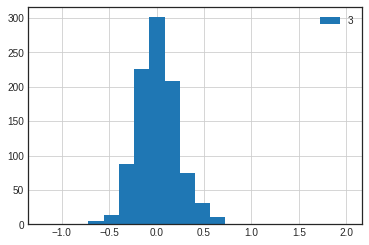

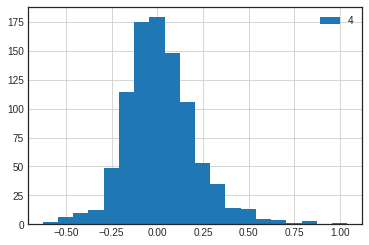

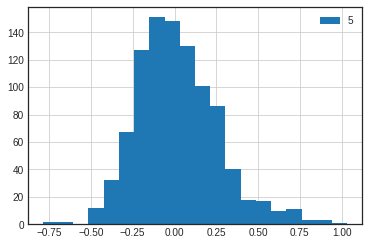

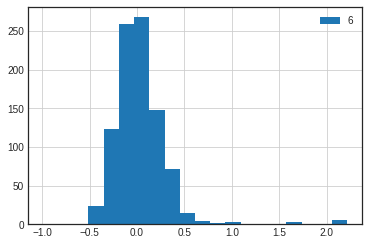

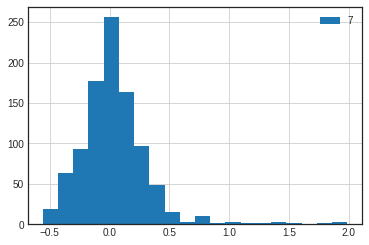

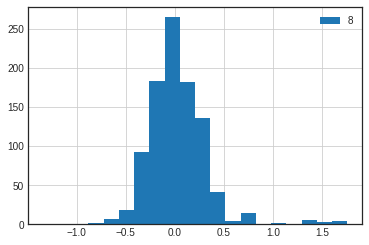

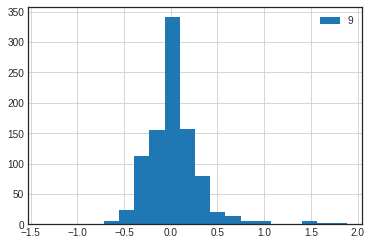

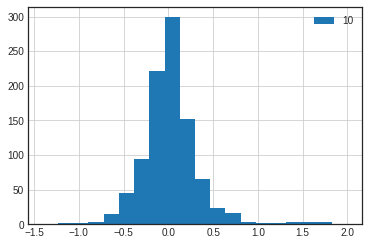

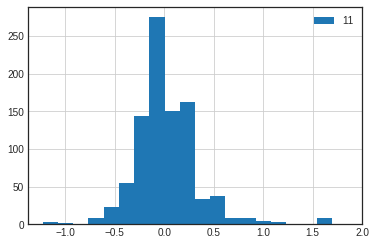

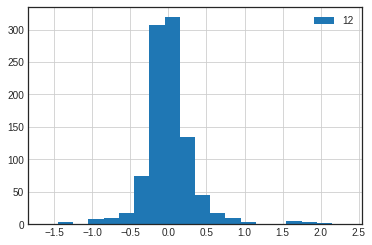

In [10]:
# monthly lambdas
for i in range(1,13):
    n=str(i)
    plt.figure()
    data['lambda'].loc[data['month']== i].hist(bins=20, label=n)
    plt.legend()

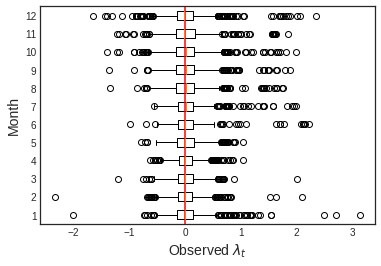

In [11]:
# monthly lambdas
fig, ax = plt.subplots()
ax.boxplot([data['lambda'].loc[data['month']== 1],data['lambda'].loc[data['month']== 2],
            data['lambda'].loc[data['month']== 3],data['lambda'].loc[data['month']== 4],
            data['lambda'].loc[data['month']== 5],data['lambda'].loc[data['month']== 6],
            data['lambda'].loc[data['month']== 7],data['lambda'].loc[data['month']== 8],
            data['lambda'].loc[data['month']== 9],data['lambda'].loc[data['month']== 10],
            data['lambda'].loc[data['month']== 11],data['lambda'].loc[data['month']== 12]],
            vert=False)
ax.axvline(x=0, color='red')
ax.set_ylabel('Month', size=14)
ax.set_xlabel('Observed $\lambda_t$', size=14)
plt.show()

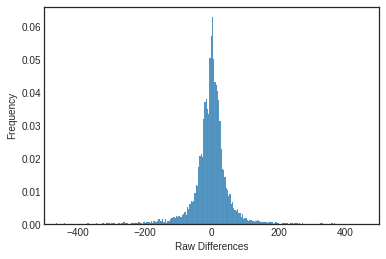

In [12]:
# raw differences (residuals)
sns.histplot(data['raw diff'],stat='probability')
plt.xlabel('Raw Differences')
plt.ylabel('Frequency')
plt.xlim([-500, 500])
plt.show()

## <font color='green'> Determine ARMA Model Orders </font>

The next step is to determine which time series model to fit to our data. We assumed an autoregressive moving average (ARMA) model. We need to determine the order of the autoregressive and moving average components. 

To do so, we test $p\in{\bigl\lbrace0,1,2,3,4\bigr\rbrace}$ for AR and $q\in{\bigl\lbrace0,1,2,3,4\bigr\rbrace}$ for MA. We base our selection on AIC and BIC, metrics of model performance.

For the Shasta, we find that for AR, $p = 4$ and for MA, $q = 0$. While this is not the set with the lowest AIC/BIC, it performs similarly to the "better" performing models and has the advantage of being simpler (no MA terms). 

Note: there are more complicated time series models with additional terms available. Specifically, one could fit a SARIMA model which includes terms for seasonal components $S$ and trend in the data $I$.

In [5]:
# # Code to find ARIMA order - this may also take some time
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# order_aic_bic =[]
# for p in range(4): # Loop over AR order
#     for q in range(4): # Loop over MA order
#         # Fit model       
#         #model = SARIMAX(data['lambda'], order=(p,0,q)) #assume there is no trend so d = 0  
#         model = sm.tsa.arima.model.ARIMA(data['lambda'], order=(p,0,q))
#         results = model.fit() 
#         order_aic_bic.append((p, q, results.aic, results.bic)) # Add order and scores to list       

# # Make DataFrame of model order and AIC/BIC scores
# order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

# display(order_df.sort_values(by='aic'))

In [ ]:
# Code to find ARIMA order - this may also take some time
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic =[]
for p in range(5): # Loop over AR order
    for q in range(5): # Loop over MA order
        # Fit model       
        #model = SARIMAX(data['lambda'], order=(p,0,q)) #assume there is no trend so d = 0  
        model = sm.tsa.arima.model.ARIMA(data['lambda'], order=(p,0,q))
        results = model.fit() 
        order_aic_bic.append((p, q, results.aic, results.bic)) # Add order and scores to list       

# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

display(order_df.sort_values(by='aic'))

## <font color='green'> Fit ARMA Model to Data </font>

Here we fit an AR4 model to our "lambdas" to get the model residuals and parameters.

In [5]:
p=4 #order of AR (autocorrelation with lag 4)
d=0 #order of I (no trend)
q=0 #order of MA (no moving average component)

mod = ARIMA(data['lambda'], order=(p,d,q)) #set up AR4 model using lambdas as input
res = mod.fit() #fit model

In [6]:
res.params #display the model parameters

const     0.023440
ar.L1     0.165057
ar.L2     0.187447
ar.L3     0.147261
ar.L4     0.137038
sigma2    0.067909
dtype: float64

Since we fit an AR4 model for this data, we have five parameters: a coefficient for each AR component (L1, L2, L3, and L4) and a constant term.

In [27]:
#create a column in data for the model residuals associated with each time step
data['Ar_res']=res.resid
data.head(5)

,date,Qgage,Qmodel,month,lambda,raw diff,97.5 quantile,2.5 quantile,25 quantile,75 quantile,Ar_res
0,1987-10-01,59.938142,366.261850,10,1.810035,306.323708,58.785179,58.785179,58.785179,58.785179,1.786596
1,1987-10-02,99.896904,735.416652,10,1.996299,635.519749,97.975298,97.975298,97.975298,97.975298,1.411201
2,1987-10-03,99.896904,550.188717,10,1.706123,450.291814,97.975298,97.975298,97.975298,97.975298,0.761985
3,1987-10-04,79.917523,421.519228,10,1.662870,341.601705,78.380238,78.380238,78.380238,78.380238,0.583921
4,1987-10-05,99.896904,336.630618,10,1.214848,236.733714,97.975298,97.975298,97.975298,97.975298,0.070037


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

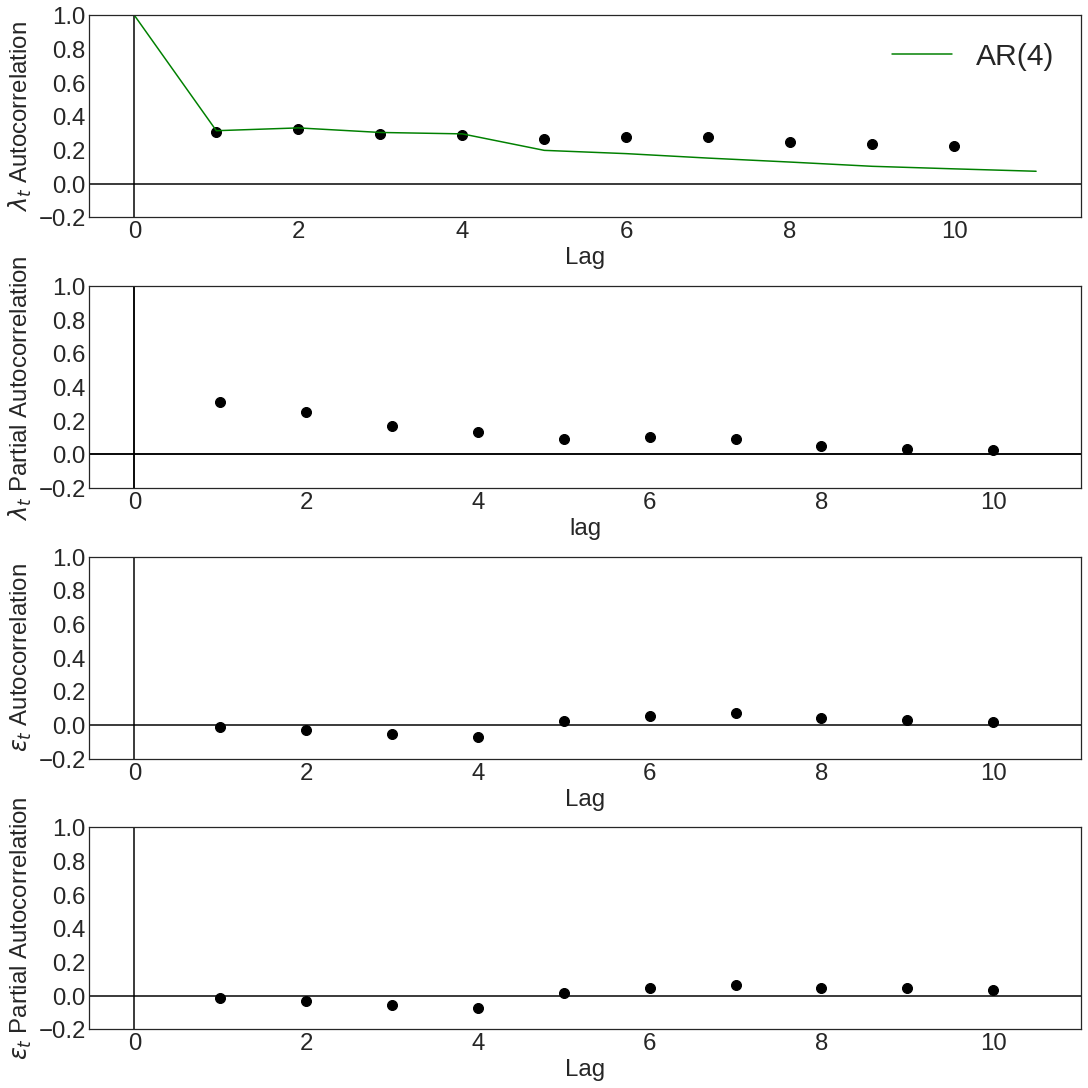

In [7]:
#calculating theoretical AR4 ACF
 
ar = np.r_[1, -1*res.arparams]
ma = np.r_[1, []]
Theoretical_ACF=sm.tsa.arima_process.ArmaProcess(ar, ma).acf(lags=125)


fig = plt.figure(figsize=(15,15),constrained_layout=True)

gs = fig.add_gridspec(8, 4, wspace=0.02,hspace=0.01)

sub1 = fig.add_subplot(gs[0:2, :])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
sm.graphics.tsaplots.plot_acf(data['lambda'], lags=10,alpha=1,zero=False,ax=sub1,color='k', markersize=10, use_vlines=False)

# add the following line for adding theoretical AR(4)
sub1.plot(np.arange(0,12),Theoretical_ACF[0:12],color='g',label='AR(4)')

sub1.set_xlabel('Lag', size=24)
sub1.set_ylabel('$\lambda_t$ Autocorrelation', size=24)
sub1.set_ylim(-0.2,1)
sub1.set_title('')
plt.xticks(size=24)
plt.yticks(size=24)
plt.legend(fontsize=30)
sub2 = fig.add_subplot(gs[2:4, :])
sub2.set_title('')

#sm.graphics.tsa.plot_acf(data['lambda'], lags=10,alpha=0.5)
sub2.axhline(y=0, color='k')
sub2.axvline(x=0, color='k')
sm.graphics.tsaplots.plot_pacf(data['lambda'], lags=10,alpha=1,zero=False,ax=sub2,color='k',vlines_kwargs={"colors": 'k', "linewidth":3}, markersize=10, use_vlines=False)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
sub2.set_xlabel('lag', size=24)
sub2.set_ylabel('$\lambda_t$ Partial Autocorrelation ', size=24)
sub2.set_ylim(-0.2,1)
sub2.set_title('')
plt.xticks(size=24)
plt.yticks(size=24)
sub3 = fig.add_subplot(gs[4:6, :])
sub3.axhline(y=0, color='k')
sub3.axvline(x=0, color='k')
sm.graphics.tsaplots.plot_acf(data['Ar_res'], lags=10,alpha=1,zero=False,ax=sub3,color='k',vlines_kwargs={"colors": 'k', "linewidth":3}, markersize=10 ,use_vlines=False)

#sm.graphics.tsa.plot_pacf(data['lambda'], lags=10,alpha=0.5, ax=ax[1])
sub3.set_xlabel('Lag', size=24)
sub3.set_ylabel('$\epsilon_t$ Autocorrelation',size=24)
sub3.set_ylim(-0.2,1)
sub3.set_title('')
plt.xticks(size=24)
plt.yticks(size=24)

sub4 = fig.add_subplot(gs[6:8, :])
sub4.axhline(y=0, color='k')
sub4.axvline(x=0, color='k')
sm.graphics.tsaplots.plot_pacf(data['Ar_res'], lags=10,alpha=1,zero=False,ax=sub4,color='k',vlines_kwargs={"colors": 'k', "linewidth":3}, markersize=10 ,use_vlines=False)

#sm.graphics.tsa.plot_pacf(data['lambda'], lags=10,alpha=0.5, ax=ax[1])
sub4.set_xlabel('Lag', size=24)
sub4.set_ylabel('$\epsilon_t$ Partial Autocorrelation',size=24)
sub4.set_ylim(-0.2,1)
sub4.set_title('')
plt.xticks(size=24)
plt.yticks(size=24)

## <font color = 'green'> Generate Random AR Parameter Sets </font>

We generate $m$ random AR parameter sets (called "Beta") to consider the uncertainty in the AR model parameters.

We use the Numpy function **random.multivariate_normal** to generate the parameter sets. This function samples the parameters from a multivariate normal distribution. The inputs to the function are the mean **(res.params)**, the covariance **(res.cov_params)**, and the number of parameter sets to generate. 

In [9]:
# m is the number of random AR parameter sets, Beta, generated for considering AR model uncertainty.
m = 100

# older version of ARIMA function
#Beta=np.random.multivariate_normal(np.array(res.params), np.array(res.cov_params()), m)

# updated Beta for using newer version of statsmodels ARIMA code
# Beta=np.random.multivariate_normal(np.array(res.params[:-1]), np.array(res.cov_params())[:-1,:-1], m)

# for reproducible Betas, use scipy.stats multivariate_normal function instead, setting random seed
Beta = stats.multivariate_normal(np.array(res.params[:-1]),np.array(res.cov_params())[:-1,:-1], seed=16)
Beta = Beta.rvs(m)

## <font color = 'green'> Generate Stochastic Residuals Using Simple Bootstrap </font>

There are 3 steps to generating the stochastic streamflow realizations:<br>

1. Generate stochastic residuals (use either simple bootstrap, conditional bootstrap, or k-Nearest Neighbors bootstrap)
2. Generate stochastic log errors by combining AR model uncertainty + stochastic residuals in AR4 model
3. Generate stochastic streamflow by transforming from log-ratios back to streamflows, including bias correction factor<br>

### <font color = 'green'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Step 1: Generate Stochastic Residuals <green>

In [10]:
# KNN bootstrap with k = 700 (k should be calibrated to the basin)
n = 100 # n is the number of stochastic streamflow realizations generated for each Beta set
Epsilon = pd.DataFrame(res.resid) # make dataframe of residuals
Epsilon['Qmodel'] = np.array(data['Qmodel']) #add in column to dataframe of modeled flows
Epsilon = np.array(Epsilon) # turn dataframe into numpy array

E = [] #initialize empty list to store errors
for t in range(0,len(data)): # loop through all time periods
    E.append(Epsilon - [0,Epsilon[t,1]])  # first column residual, second column diff between flow and all other flows


#K = [116, 200, 300, 500, 600, 700, 1000, 3000]
k = 750

Er = np.zeros((len(data),k)) #initialize empty 2d array with dimensions time periods x k (# nearest neighbors)
for t in range(0,len(data)): #loop through all time periods
    E[t][:,1] = np.abs(E[t][:,1]) #get absolute values of errors
    x = E[t][np.argsort(E[t][:, 1])] #sort errors by magnitude
    Er[t,:] = x[0:k,0]
    

R = np.zeros((len(data),n*m)) #initialize empty 2d array with dimensions time periods x # realizations
for i in range(0,n*m): #loop through all realizations
    I = np.random.randint(low=0, high=k, size=len(data)) #randomly identify indices
    R[:,i] = Er[tuple(np.arange(0,len(data),1)),I] #sample from Er at random indices I
    
E = R #set E to equal R

One needs to experiment with different k values to find the appropriate k for each basin by going trough all the next steps of the SWM and diagnostic figures.  

### <font color='green'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Step 2: Generate Stochastic Log Errors </font>

In [11]:
# l is a matrix of [len(data),m*n] representing stochastic log-ratio errors         
L = np.zeros((len(data),m*n)) #initialize empty array to populate below

# for the first five time periods, we set values to be the deterministic model lambdas across all realizations
# this is because we do not have enough time periods in the past to populate the AR4 model stochastically
for i in range(0,m*n):
    L[0:5,i] = data['lambda'].iloc[0:5] 

for i in range(0,m):    
    B = Beta[i,:] #let B = random parameter set for realization i
    for t in range(5,len(data)):
        # L(t) = B0 + B1*L[t-1] + B2*L[t-2] + B3*L[t-3] + B4*L[t-4] + E[t]
        L[t, i*n:((i+1)*n)] = B[0] + \
                              B[1] * L[t-1, i*n:((i+1)*n)] + \
                              B[2] * L[t-2, i*n:((i+1)*n)] + \
                              B[3] * L[t-3, i*n:((i+1)*n)] + \
                              B[4] * L[t-4, i*n:((i+1)*n)] + \
                              E[t, i*n:((i+1)*n)]

### <font color = 'green'> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Step 3: Generate Stochastic Streamflows </font>

In [12]:
# Q is a matrix of stochastically simulated streamflows of size [m*n, len(data)]
# Just like lambda = log(Qmodel/Qgage), we now set Q = Qmodel/e^L where
# L is stochastic lambdas and Q is stochastic streamflow
Q = np.array(data['Qmodel']) / np.exp(L.T)

# BCF is transformation bias correction factor 
# this address the bias introduced by moving to log space
BCF = 1 / np.exp(-np.mean(data['lambda']) + np.var(data['lambda'])/2)

Q = Q*BCF

In [13]:
print(BCF)

0.9807641078478005


In [14]:
display(pd.DataFrame(Q))

,0,1,2,3,4,5,6,7,8,9,...,11313,11314,11315,11316,11317,11318,11319,11320,11321,11322
0,58.785179,97.975298,97.975298,78.380238,97.975298,90.038529,102.996390,91.182705,104.813984,100.671687,...,78.389144,75.214148,65.325465,64.368328,81.512047,84.614308,68.303503,66.604181,60.692049,88.913717
1,58.785179,97.975298,97.975298,78.380238,97.975298,85.683221,102.980522,105.293568,92.853136,104.282799,...,62.716215,85.226725,100.129133,66.210494,89.999142,135.867338,143.177724,106.849827,76.947829,123.154962
2,58.785179,97.975298,97.975298,78.380238,97.975298,94.032950,107.799681,99.692317,96.735594,123.387077,...,85.673653,96.811551,42.024430,55.883262,95.525398,69.736181,86.657575,79.720293,118.144073,113.905591
3,58.785179,97.975298,97.975298,78.380238,97.975298,85.053383,97.895267,101.769692,97.864976,98.787384,...,145.346502,106.417100,85.708006,71.433371,108.964068,100.025349,97.181130,99.082194,74.934826,104.380943
4,58.785179,97.975298,97.975298,78.380238,97.975298,92.168660,91.204609,97.027287,113.566974,145.795693,...,77.306172,72.001946,64.671400,53.782496,57.143899,62.491689,64.513092,74.648959,77.809398,120.153310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,58.785179,97.975298,97.975298,78.380238,97.975298,99.635836,102.934055,94.401314,112.053533,110.267139,...,64.130468,71.962080,88.274417,58.260733,66.247505,17.442261,47.495134,44.696129,55.403116,11.948892
9996,58.785179,97.975298,97.975298,78.380238,97.975298,92.312664,72.086888,86.110602,106.641952,94.514628,...,51.241966,68.806342,88.615115,71.201014,100.800514,116.120260,19.861828,51.381835,71.584086,61.408606
9997,58.785179,97.975298,97.975298,78.380238,97.975298,94.611029,87.832387,96.835001,92.073307,82.375870,...,65.892555,64.720672,59.549283,65.944317,77.334853,64.658523,52.604617,79.548036,77.165273,67.358232
9998,58.785179,97.975298,97.975298,78.380238,97.975298,100.390384,97.209585,104.523016,130.777540,105.964064,...,137.625895,119.715699,87.394455,106.857415,75.166587,83.580531,91.825325,96.465026,91.260517,135.114181


In [15]:
display(pd.DataFrame(L.T))

,0,1,2,3,4,5,6,7,8,9,...,11313,11314,11315,11316,11317,11318,11319,11320,11321,11322
0,1.810035,1.996299,1.706123,1.66287,1.214848,1.113152,0.821359,0.820978,0.606044,0.575590,...,-0.002413,0.034295,0.171813,0.183688,-0.056023,-0.097879,0.111469,0.132268,0.272114,0.110920
1,1.810035,1.996299,1.706123,1.66287,1.214848,1.162733,0.821513,0.677091,0.727212,0.540348,...,0.220652,-0.090681,-0.255266,0.155471,-0.155072,-0.571454,-0.628657,-0.340389,0.034799,-0.214857
2,1.810035,1.996299,1.706123,1.66287,1.214848,1.069745,0.775778,0.731755,0.686249,0.372128,...,-0.091273,-0.218132,0.612943,0.325045,-0.214664,0.095505,-0.126535,-0.047489,-0.393978,-0.136784
3,1.810035,1.996299,1.706123,1.66287,1.214848,1.170111,0.872155,0.711131,0.674642,0.594485,...,-0.619848,-0.312732,-0.099752,0.079544,-0.346290,-0.265199,-0.241147,-0.264915,0.061308,-0.049461
4,1.810035,1.996299,1.706123,1.66287,1.214848,1.089770,0.942948,0.758851,0.525838,0.205248,...,0.011498,0.077941,0.181875,0.363362,0.299155,0.205191,0.168562,0.018239,0.023664,-0.190182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.810035,1.996299,1.706123,1.66287,1.214848,1.011868,0.821964,0.786288,0.539254,0.484549,...,0.198353,0.078495,-0.129256,0.283381,0.151330,1.481329,0.474803,0.531148,0.363291,2.117948
9996,1.810035,1.996299,1.706123,1.66287,1.214848,1.088209,1.178181,0.878211,0.588754,0.638700,...,0.422713,0.123338,-0.133108,0.082803,-0.268416,-0.414402,1.346630,0.391750,0.107054,0.481036
9997,1.810035,1.996299,1.706123,1.66287,1.214848,1.063616,0.980623,0.760835,0.735646,0.776162,...,0.171247,0.184553,0.264390,0.159499,-0.003417,0.171105,0.372626,-0.045326,0.031977,0.388561
9998,1.810035,1.996299,1.706123,1.66287,1.214848,1.004324,0.879184,0.684436,0.384733,0.524355,...,-0.565267,-0.430486,-0.119237,-0.323186,0.025021,-0.085586,-0.184458,-0.238145,-0.135792,-0.307534


In [16]:
data

,date,Qgage,Qmodel,month,lambda,raw diff,Ar_res
0,1987-10-01,59.938142,366.261850,10,1.810035,306.323708,1.786596
1,1987-10-02,99.896904,735.416652,10,1.996299,635.519749,1.411201
2,1987-10-03,99.896904,550.188717,10,1.706123,450.291814,0.761985
3,1987-10-04,79.917523,421.519228,10,1.662870,341.601705,0.583921
4,1987-10-05,99.896904,336.630618,10,1.214848,236.733714,0.070037
...,...,...,...,...,...,...,...
11318,2018-09-26,79.917523,78.229589,9,-0.021347,-1.687934,-0.022115
11319,2018-09-27,79.917523,77.855393,9,-0.026142,-2.062129,-0.024599
11320,2018-09-28,59.938142,77.513991,9,0.257145,17.575849,0.261246
11321,2018-09-29,79.917523,81.235286,9,0.016355,1.317763,-0.024250


## <font color = 'green'> Save Outputs </font>

Outputs saved as **.npy** files. The outputs are:

1. E.npy: stochastic residuals
2. L.npy: stochastic log ratios
3. Q.npy: stochastic streamflows

In [17]:
# save the results as .npy files
np.save('Q_final.npy',Q)
np.save('StochasticE_final.npy',E)
np.save('L_final.npy',L)

***

# <center> <font color = 'red'> Part 2: Diagnostic Figures </font> </center>

Here, we include code to generate the following diagnostic figures:

1. Storage-Yield Curve
2. Flow Duration Curve
3. 7-day  Minimum Flow vs Exceedance Interval
4. Annual Maximum Flow vs Exceedance Interval
5. Sample Period Hydrograph
6. Recurrence Interval of Particular Flood (e.g., 100-year flood)

## <font color = 'green'> Reloading in the data </font>

In [1]:
# functions developed by Ghazal:
import Func_Lib_forAbby as func

# general packages
import numpy as np #numpy is a scientific computing package
import pandas as pd #pandas is a data analysis package
import math #math contains math functions
import time #functions in this package can be used to understand how long the code is taking to run
import os #functions related to operating system

# plotting packages
import matplotlib.pyplot as plt #matplotlib.pyplot is used for plotting
import seaborn as sns #seaborn is a plotting package
plt.style.use('seaborn-white') #this is the specific style of plotting used

# statistical analysis packages
from scipy import stats #scipy.stats are functions related to statistical analysis
from scipy.stats import norm #functions for normally distributed random variable 

# time series analysis packages
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf #function to plot autocorrelation function (acf) for time series analysis
from statsmodels.graphics.tsaplots import plot_pacf #function to plot partial autocorrelation function (pacf) for time series analysis
#from statsmodels.tsa.arima_model import ARIMA #import function for ARIMA (time series analysis)
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# read in the csv of streamflow data and assign to variable called "data"
data = pd.read_csv('SWM-data_cond-debias.csv') #columns are date, Qgage (observed), Qmodel (deterministic model), and diff (Qmodel - Qgage)

data['month'] = pd.DatetimeIndex(data['date']).month #create a DatetimeIndex column for month
data['date'] = pd.to_datetime(data['date']) #convert format of "date" column to Datetime (for time series analysis)

#convert units to m^3/s 
# mm/day * SHA area in mi2 * (1609.34^2 m^2/mi^2) * (10^-3 m/1 mm) * (1 day/24*3600 s)
area_mi2_SHA = 6665 #area for Shasta baisn in sq. mi. from Zach Brodeur
data['Qgage'] = data['Qgage']*area_mi2_SHA*(1609.34**2)*(10**-3)/(24*3600)
data['Qmodel'] = data['Qmodel']*area_mi2_SHA*(1609.34**2)*(10**-3)/(24*3600)

# generating empirical log-ratio errors
data['lambda'] = np.log(data['Qmodel'] / data['Qgage']) #calculate the lambda = log(Qmodel/Qgage)
data['raw diff'] = data['Qmodel'] - data['Qgage']
data.head(5) #display first five rows of data

,date,Qgage,Qmodel,month,lambda,raw diff
0,1987-10-01,59.938142,366.261850,10,1.810035,306.323708
1,1987-10-02,99.896904,735.416652,10,1.996299,635.519749
2,1987-10-03,99.896904,550.188717,10,1.706123,450.291814
3,1987-10-04,79.917523,421.519228,10,1.662870,341.601705
4,1987-10-05,99.896904,336.630618,10,1.214848,236.733714


In [3]:
Q = np.load('Q_final.npy')
m=100
n=100

In [4]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,...,11313,11314,11315,11316,11317,11318,11319,11320,11321,11322
0,58.785179,97.975298,97.975298,78.380238,97.975298,90.038529,102.996390,91.182705,104.813984,100.671687,...,78.389144,75.214148,65.325465,64.368328,81.512047,84.614308,68.303503,66.604181,60.692049,88.913717
1,58.785179,97.975298,97.975298,78.380238,97.975298,85.683221,102.980522,105.293568,92.853136,104.282799,...,62.716215,85.226725,100.129133,66.210494,89.999142,135.867338,143.177724,106.849827,76.947829,123.154962
2,58.785179,97.975298,97.975298,78.380238,97.975298,94.032950,107.799681,99.692317,96.735594,123.387077,...,85.673653,96.811551,42.024430,55.883262,95.525398,69.736181,86.657575,79.720293,118.144073,113.905591
3,58.785179,97.975298,97.975298,78.380238,97.975298,85.053383,97.895267,101.769692,97.864976,98.787384,...,145.346502,106.417100,85.708006,71.433371,108.964068,100.025349,97.181130,99.082194,74.934826,104.380943
4,58.785179,97.975298,97.975298,78.380238,97.975298,92.168660,91.204609,97.027287,113.566974,145.795693,...,77.306172,72.001946,64.671400,53.782496,57.143899,62.491689,64.513092,74.648959,77.809398,120.153310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,58.785179,97.975298,97.975298,78.380238,97.975298,99.635836,102.934055,94.401314,112.053533,110.267139,...,64.130468,71.962080,88.274417,58.260733,66.247505,17.442261,47.495134,44.696129,55.403116,11.948892
9996,58.785179,97.975298,97.975298,78.380238,97.975298,92.312664,72.086888,86.110602,106.641952,94.514628,...,51.241966,68.806342,88.615115,71.201014,100.800514,116.120260,19.861828,51.381835,71.584086,61.408606
9997,58.785179,97.975298,97.975298,78.380238,97.975298,94.611029,87.832387,96.835001,92.073307,82.375870,...,65.892555,64.720672,59.549283,65.944317,77.334853,64.658523,52.604617,79.548036,77.165273,67.358232
9998,58.785179,97.975298,97.975298,78.380238,97.975298,100.390384,97.209585,104.523016,130.777540,105.964064,...,137.625895,119.715699,87.394455,106.857415,75.166587,83.580531,91.825325,96.465026,91.260517,135.114181


## <font color = 'green'> Generating Figure Inputs </font>

In [5]:
# calculating information needed for a storage yield curve
storageSynt, AnnualVolume, R = func.Storage_yield(Q, data, m*n)

# calculating inputs for flow duration curve: sorted stochastic flow, exceedance , non-exceedance, rank, and observation columns
Stochastic = func.Flow_Exceedance(Q, data, m*n)

In [6]:
Q7_95, Q7_99, Q7_50, data = func.confidenceband_p(data,Q)

# calculating the coverage probability of the stochastic simulation for 50% and 95% confidence intervals
Qobs = np.array(data['Qgage'])
Qband50 = np.zeros(len(Qobs))
Qband95 = np.zeros(len(Qobs))

for t in range (0, len(Qobs)):
    Qband50[t] = (Qobs[t] >= Q7_50[0][t]) and (Qobs[t]<= Q7_50[1][t])
    Qband95[t] = (Qobs[t] >= Q7_95[0][t]) and (Qobs[t]<= Q7_95[1][t])
    
Band50_ratio = np.mean(Qband50)
Band95_ratio = np.mean(Qband95)
print('Ratio of observations in the 95% confidence interval:', Band95_ratio)
print('Ratio of observations in the 50% confidence interval:', Band50_ratio)

Ratio of observations in the 95% confidence interval: 0.9442727192440166
Ratio of observations in the 50% confidence interval: 0.458005828843946


In [7]:
# generating annual maximums and their exceedance probability
Annualmax = func.annualmax(Q, data, m*n)

# generating minimum of 7-day averages and their exceedance probability  
low7 = func.low7day(Q, data, m*n)

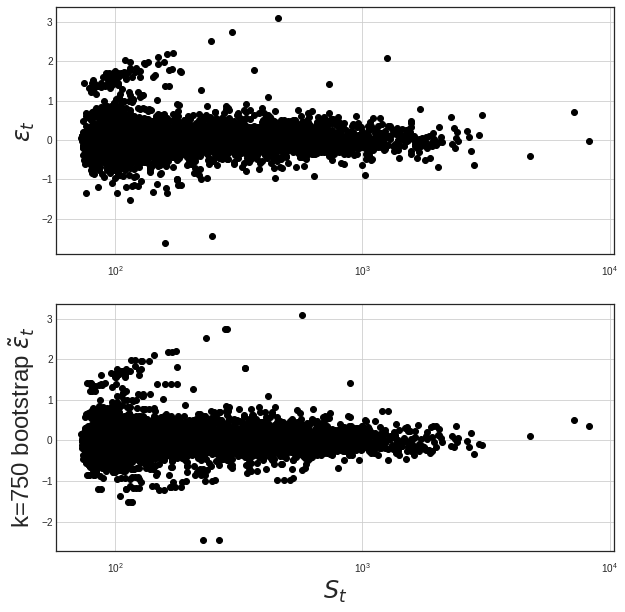

In [29]:
# generating the scatter plot of emperical epsilon vs. flow

fig, ax = plt.subplots(2,figsize=(10,10))
r=np.random.randint(0,n*m)

ax[0].scatter(data['Qmodel'],data['Ar_res'], color='k')
ax[0].grid()
ax[0].set_xscale('log')
ax[0].set_ylabel('$\epsilon_t$',rotation=90, size= 24)
ax[0].tick_params(axis='x', which='major', pad=10)

ax[1].scatter(data['Qmodel'],E[:,r], color='k')
ax[1].grid()
ax[1].set_xscale('log')
#ax[1].set_ylabel('k-NN $\~\epsilon_t$',rotation=90, size=24)
ax[1].set_ylabel('k=750 bootstrap $\~\epsilon_t$',rotation=90, size=24)
ax[1].set_xlabel('$S_t$', size= 24)
ax[1].tick_params(axis='x', which='major', pad=10)
#plt.savefig('AR_resflow.png',dpi=1000)

## <font color = 'green'> Figures </font>

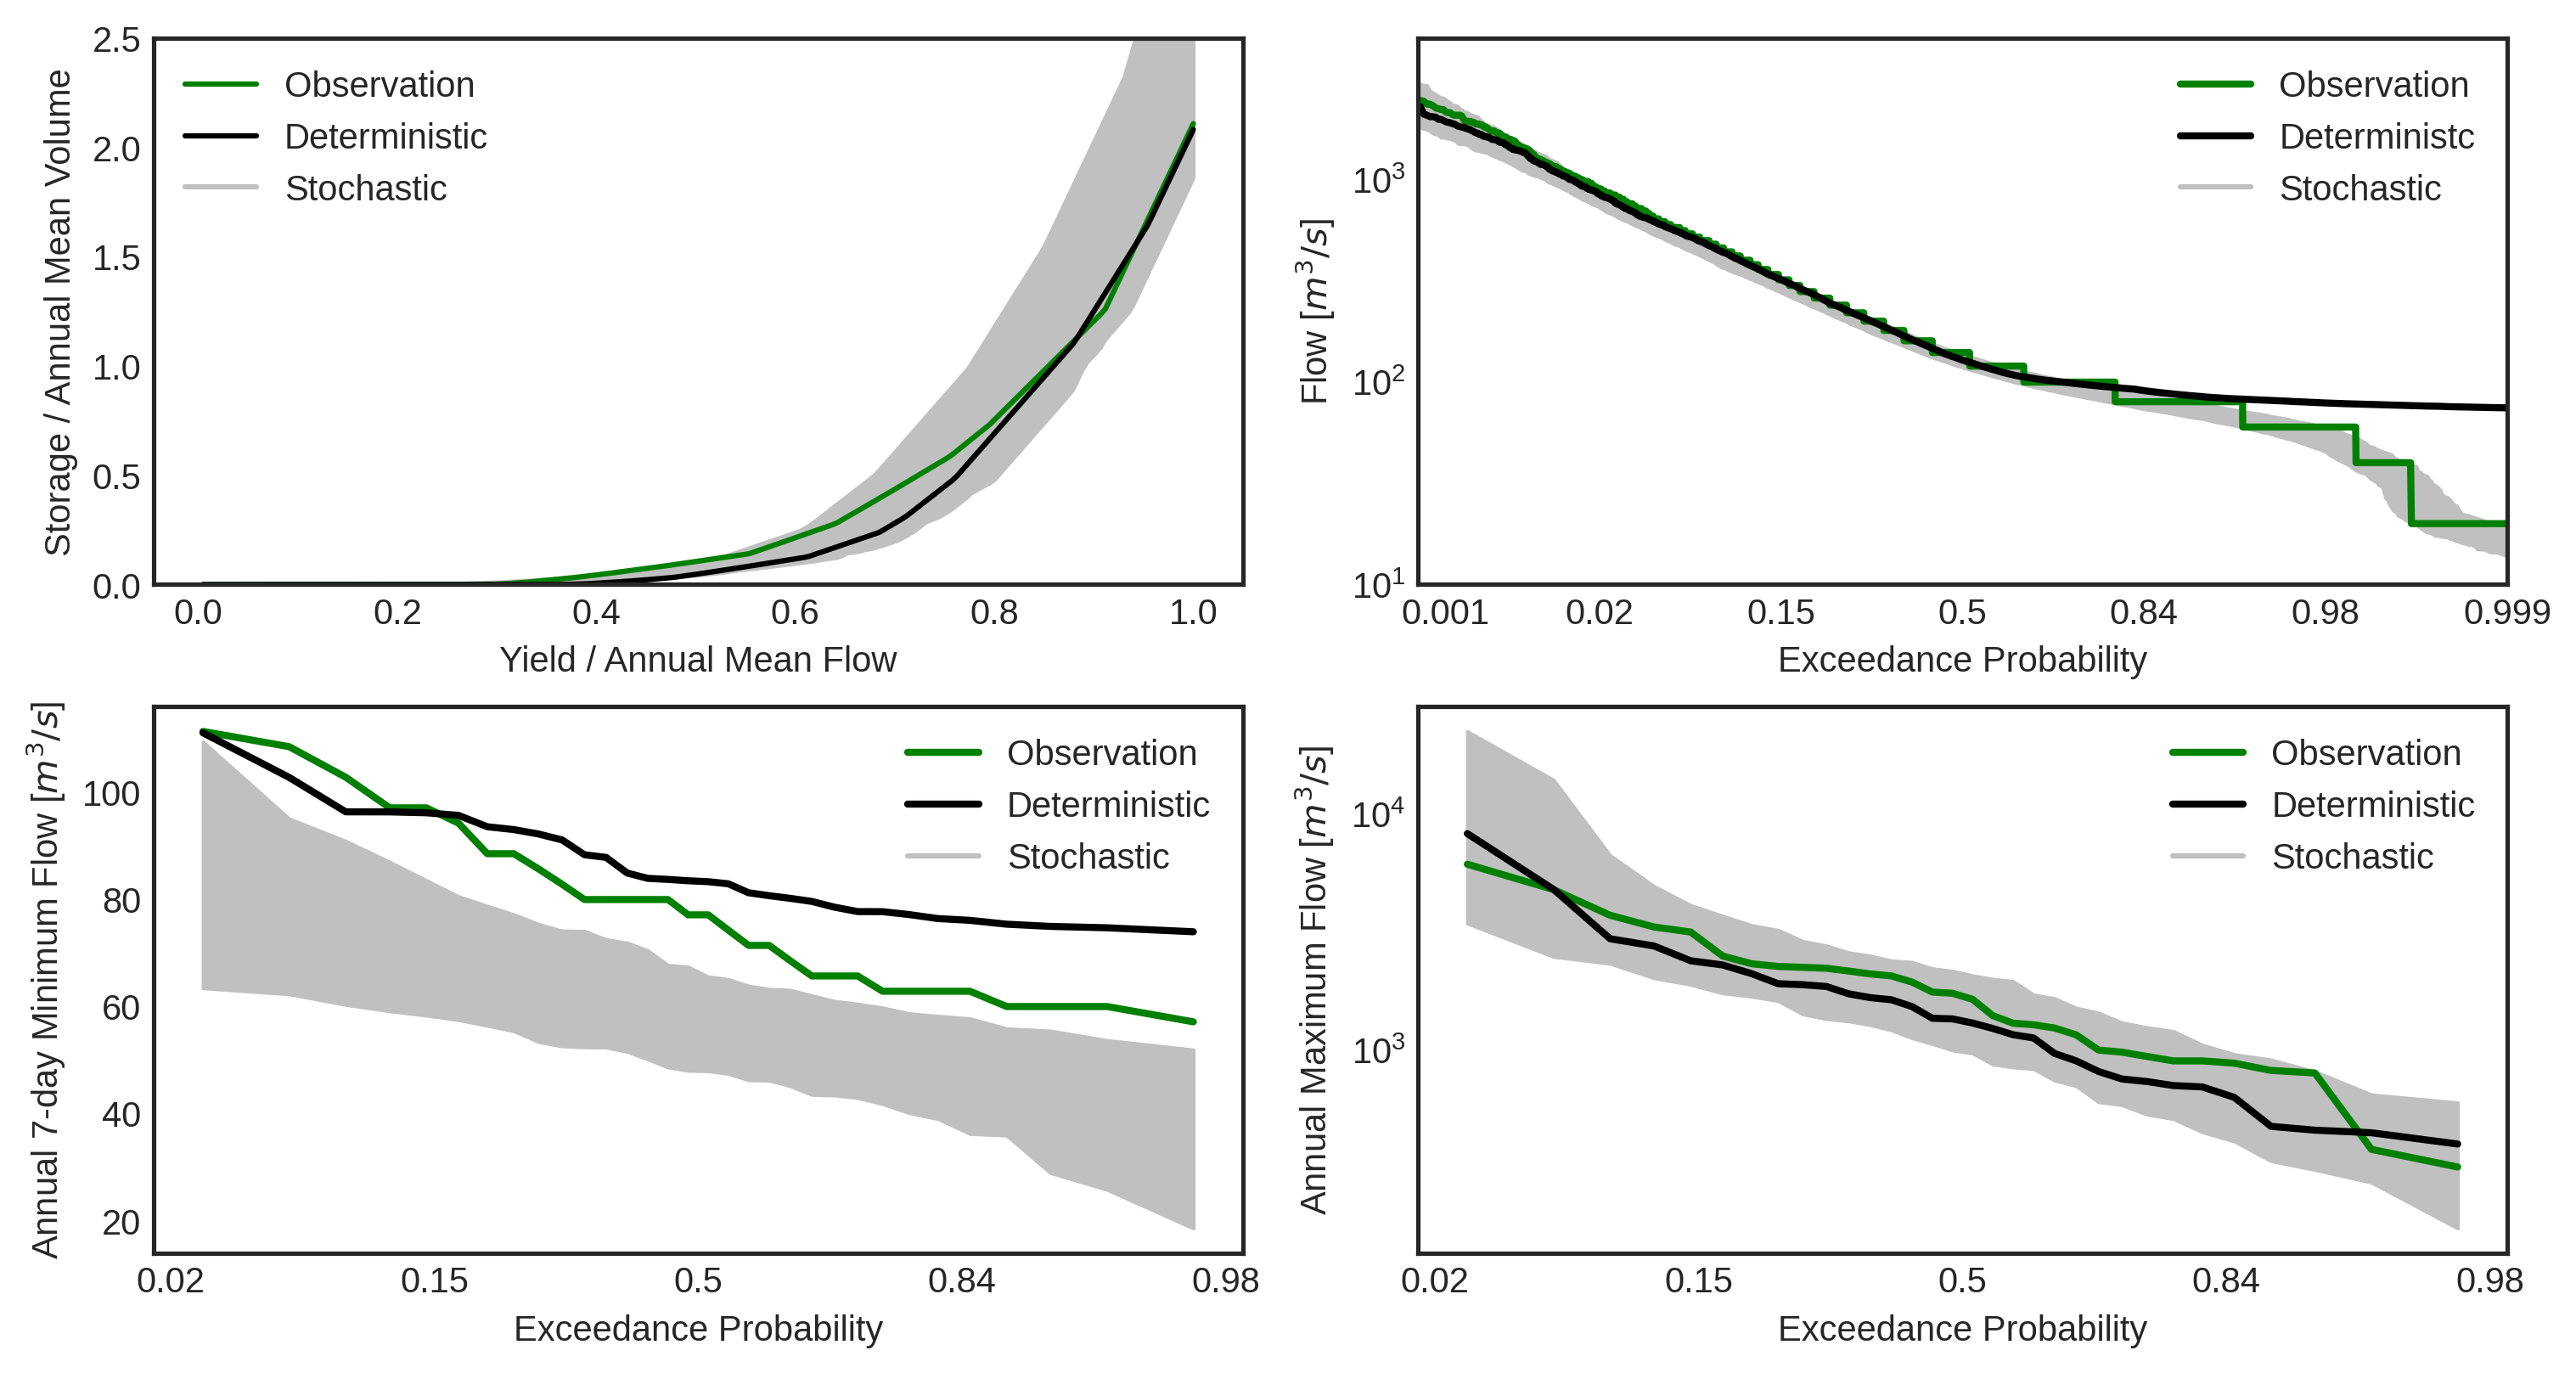

In [8]:
# set figure parameters
fig = plt.figure(figsize=(10,10), constrained_layout=True, dpi=300)
gs = fig.add_gridspec(8, 4, wspace=0.05, hspace=0.05)

# first subplot: storage yield curve
sub1 = fig.add_subplot(gs[0:2,0:2])

strg = np.array(storageSynt)[:,0:m*n]
strg_max_min = pd.DataFrame(np.max(strg,axis=1))
strg_max_min['min'] = np.min(strg,axis=1)
Rt = np.linspace(1, R, len(storageSynt))

sub1.fill_between(Rt/R, strg_max_min['min']/AnnualVolume, strg_max_min[0]/AnnualVolume, color='silver')
sub1.plot(Rt/R, storageSynt[:,storageSynt.shape[1]-2]/AnnualVolume, color= 'g', label='Observation')
sub1.plot(Rt/R, storageSynt[:,storageSynt.shape[1]-1]/AnnualVolume, color='k', label='Deterministic')
sub1.set_xlabel('Yield / Annual Mean Flow')
sub1.set_ylabel('Storage / Annual Mean Volume')
sub1.plot([],[], 'silver', label='Stochastic')
sub1.legend(loc='best')
sub1.set_ylim(0,2.5)

# second subplot: Flow duration curve
sub2 = fig.add_subplot(gs[0:2,2:4])
S = np.array(Stochastic)[:,0:m*n]
S_max_min = pd.DataFrame(np.max(S,axis=1))
S_max_min['min'] = np.min(S,axis=1)

sub2.fill_between(norm.ppf(Stochastic['Exeedance']), S_max_min['min'], S_max_min[0], color='silver')
ax1 = sub2.plot(norm.ppf(Stochastic['Exeedance']), Stochastic['obs'], color='green', lw=2, label='Observation')
ax2 = sub2.plot(norm.ppf(Stochastic['Exeedance']), Stochastic['model'], color='k', lw=2, label='Deterministc')
sub2.set_ylabel('Flow [$m^3/s$]')
sub2.set_xlabel('Exceedance Probability')
plt.xticks([-2.85,-2,-1,0,1,2,3], [0.001,0.02,0.15,0.5,0.84,0.98,0.999])
sub2.set_xlim(-3,3)
sub2.set_ylim(10, 5000)
sub2.set_yscale('log')
sub2.plot([],[], 'silver', label='Stochastic')
sub2.legend(loc='best')

# third subplot: 7-day min flow
sub3 = fig.add_subplot(gs[2:4,0:2])
sub3.fill_between(norm.ppf(np.array(low7['Exeedance'])), np.array(low7)[:,0:m*n].max(axis=1), np.array(low7)[:,0:m*n].min(axis=1), color='silver')
sub3.plot(norm.ppf(low7['Exeedance']), low7['obs'], color='green', lw=2, label='Observation')
sub3.plot(norm.ppf(low7['Exeedance']), low7['model'], color='k', lw=2, label='Deterministic')
sub3.set_ylabel('Annual 7-day Minimum Flow [$m^3/s$]')
plt.xticks([-3,-2,-1,0,1,2,3], [0.001,0.02,0.15,0.5,0.84,0.98,0.999])
sub3.set_xlabel('Exceedance Probability')
sub3.plot([],[], 'silver', label='Stochastic')
sub3.legend(loc='best')

# fourth subplot: annual max flow
sub4 = fig.add_subplot(gs[2:4,2:4])
sub4.fill_between(norm.ppf(np.array(Annualmax['Exeedance'])), np.array(Annualmax)[:,0:m*n].max(axis=1), np.array(Annualmax)[:,0:m*n].min(axis=1), color='silver')
sub4.plot(norm.ppf(Annualmax['Exeedance']), Annualmax['obs'], color='green', lw=2, label='Observation')
sub4.plot(norm.ppf(Annualmax['Exeedance']), Annualmax['model'], color='k', lw=2, label='Deterministic')
sub4.set_ylabel('Annual Maximum Flow [$m^3/s$]')
sub4.set_xlabel('Exceedance Probability')
plt.xticks([-3,-2,-1,0,1,2,3], [0.001,0.02,0.15,0.5,0.84,0.98,0.999])
sub4.set_yscale('log')
sub4.plot([],[], 'silver', label='Stochastic')
sub4.legend(loc='best')

plt.savefig('4_plots_final.png', dpi=1000)

plt.show() #display plot


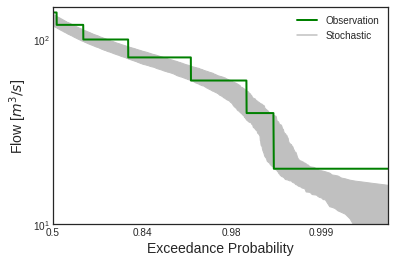

In [14]:
# zooming in on the Flow duration curve
fig = plt.figure()
sub2 = fig.add_subplot()
S = np.array(Stochastic)[:,0:m*n]
S_max_min = pd.DataFrame(np.max(S,axis=1))
S_max_min['min'] = np.min(S,axis=1)

sub2.fill_between(norm.ppf(Stochastic['Exeedance']), S_max_min['min'], S_max_min[0], color='silver')
ax1 = sub2.plot(norm.ppf(Stochastic['Exeedance']), Stochastic['obs'], color='green', lw=2, label='Observation')
#ax2 = sub2.plot(norm.ppf(Stochastic['Exeedance']), Stochastic['model'], color='k', lw=2, label='Deterministc')
sub2.set_ylabel('Flow [$m^3/s$]', size=14)
sub2.set_xlabel('Exceedance Probability', size=14)
plt.xticks([-3,-2,-1,0,1,2,3], [0.001,0.02,0.15,0.5,0.84,0.98,0.999])
sub2.set_xlim(0,3.75)
sub2.set_ylim(10, 150)
sub2.set_yscale('log')
sub2.plot([],[], 'silver', label='Stochastic')
sub2.legend(loc='best')
plt.savefig('4_plots_zoomed_final.png', dpi=1000)
plt.show()

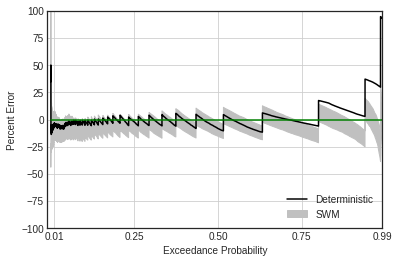

In [33]:
diff=np.zeros(Q.T.shape)
for i in range(0,m*n):
    diff[:,i]=100*(np.sort(Q.T[:,i])[::-1]-np.sort(data.Qgage)[::-1])/np.sort(data.Qgage)[::-1]

diff = pd.DataFrame(diff)
diff['model Error']=100*(np.sort(data.Qmodel)[::-1]-np.sort(data.Qgage)[::-1])/np.sort(data.Qgage)[::-1]

diff['obs']=np.sort(data.Qgage)[::-1]
diff['Rank']=diff.reset_index().index + 1
diff['Exeedance']=diff['Rank']/(len(diff)+1)
diff['non_Exceedance']=1-diff['Exeedance']

D=np.array(diff)[:,0:m*n]
d_max_min=pd.DataFrame(np.max(D,axis=1))
d_max_min['min']=np.min(D,axis=1)
plt.plot(diff['Exeedance'],diff['model Error'], color='k',label='Deterministic')
plt.fill_between(diff['Exeedance'], d_max_min['min'], d_max_min[0], color='silver',label='SWM')

plt.plot([0,1],[0,0],'-g')
plt.ylim((-100,100))
plt.xlim([-0.01,0.99])
plt.xticks([0.01,0.25,0.5,0.75,0.99])
plt.xlabel('Exceedance Probability')
plt.ylabel('Percent Error')
#plt.title(title)
plt.grid()

plt.legend(loc='lower right')

plt.show()

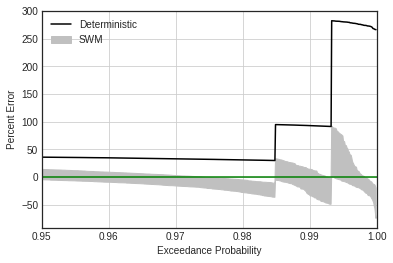

In [38]:
# zooming in on the Percent error plot
diff=np.zeros(Q.T.shape)
for i in range(0,m*n):
    diff[:,i]=100*(np.sort(Q.T[:,i])[::-1]-np.sort(data.Qgage)[::-1])/np.sort(data.Qgage)[::-1]

diff = pd.DataFrame(diff)
diff['model Error']=100*(np.sort(data.Qmodel)[::-1]-np.sort(data.Qgage)[::-1])/np.sort(data.Qgage)[::-1]

diff['obs']=np.sort(data.Qgage)[::-1]
diff['Rank']=diff.reset_index().index + 1
diff['Exeedance']=diff['Rank']/(len(diff)+1)
diff['non_Exceedance']=1-diff['Exeedance']

D=np.array(diff)[:,0:m*n]
d_max_min=pd.DataFrame(np.max(D,axis=1))
d_max_min['min']=np.min(D,axis=1)
plt.plot(diff['Exeedance'],diff['model Error'], color='k',label='Deterministic')
plt.fill_between(diff['Exeedance'], d_max_min['min'], d_max_min[0], color='silver',label='SWM')

plt.plot([0,1],[0,0],'-g')
#plt.ylim((-50,300))
#plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8], [0.01,0.25,0.5,0.75,0.99])
plt.xlim([0.95,1])
#plt.xlim([-0.01,0.99])
plt.xlabel('Exceedance Probability')
plt.ylabel('Percent Error')
#plt.title(title)
plt.grid()

plt.legend(loc='upper left')

plt.show()

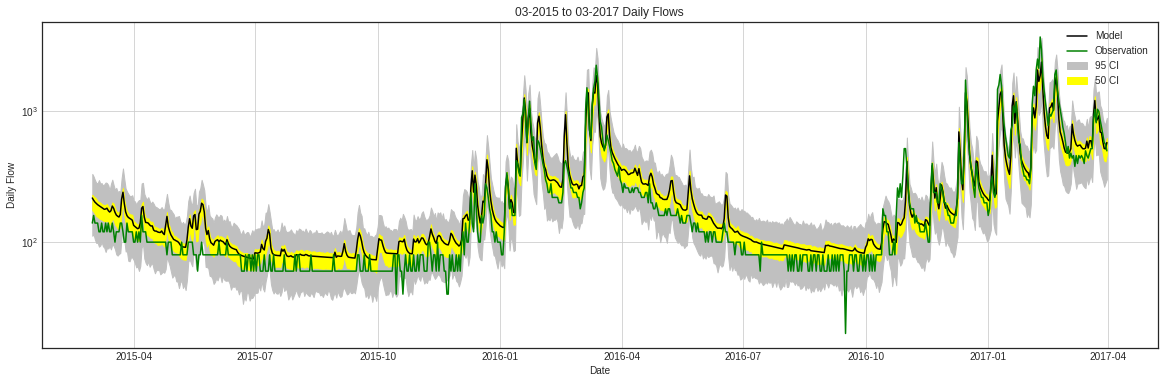

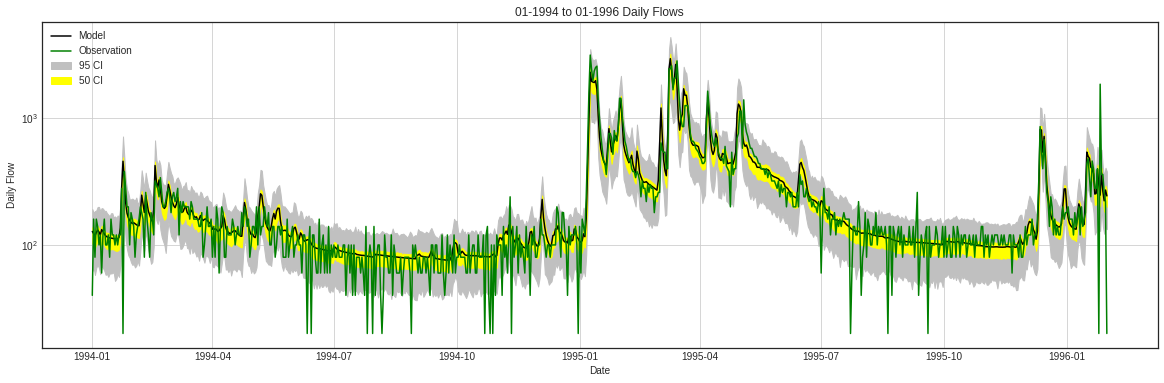

In [53]:
#plotting stochastic realizations 95% and 50% confidence intervals, observed flow, and deterministic model flow for sample years
func.hydrograph_plt(data, '03-2015', '03-2017')
func.hydrograph_plt(data, '01-1994', '01-1996')

<Figure size 432x288 with 0 Axes>

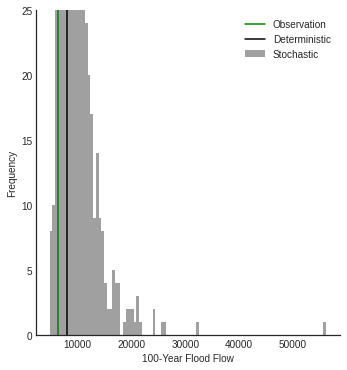

In [54]:
# here you need to find the T-year flood (2-year, 10-year, 50-year ,100-year etc.)for observation, deterministic model, and stochastic ensemble and compare these values
# find the T-year flood and their confidence intervals however USGS finds fit, software or any other method... .

flood100 = np.zeros(n*m)
for i in range(0,n*m):
    flood100[i] = func.wilson(0.99, Annualmax[i])
flood100obs = func.wilson(0.99, Annualmax['obs'])
flood100model = func.wilson(0.99, Annualmax['model'])

plt.figure()
sns.displot(flood100, kde=False, color='gray', label='Stochastic', linewidth=0)
plt.plot([flood100obs,flood100obs], [0,1000], color='g', linestyle='solid', label='Observation')
plt.plot([flood100model,flood100model], [0,1000], color='k', linestyle='solid', label='Deterministic')


ax = plt.gca()
ax.set_ylim([0, 25])

plt.xlabel('100-Year Flood Flow')
plt.ylabel('Frequency')
plt.legend(prop={'size': 10})
plt.show()